In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from numpy import dot
from numpy.linalg import norm, inv
from numpy.linalg import svd
import cv2

In [2]:
def cos_sim(a: np.array, b: np.array) -> float:
    return dot(a, b)/(norm(a)*norm(b))

In [2]:
vgg = scipy.io.loadmat('bestofgiro2022_vggfeatures.mat')["features"]
skeletons = scipy.io.loadmat('bestofgiro2022_skeletons.mat')["skeldata"]
clip = scipy.io.loadmat('bestofgiro2022_clipfeatures.mat')["features"]

# VGG features

In [4]:
print(f"There are {vgg.shape[1]} image vectors of size {vgg.shape[0]}")

There are 13971 image vectors of size 512


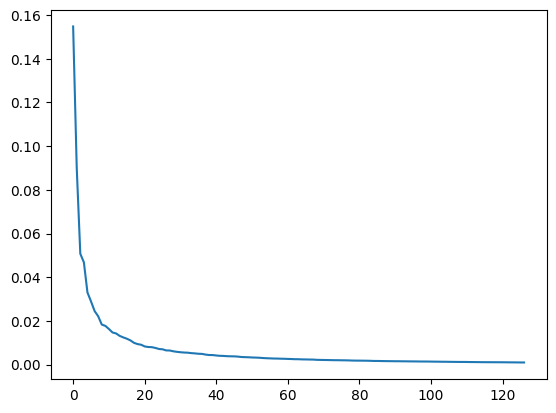

In [5]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(vgg.T)

plt.plot(pca.explained_variance_ratio_)
plt.show()

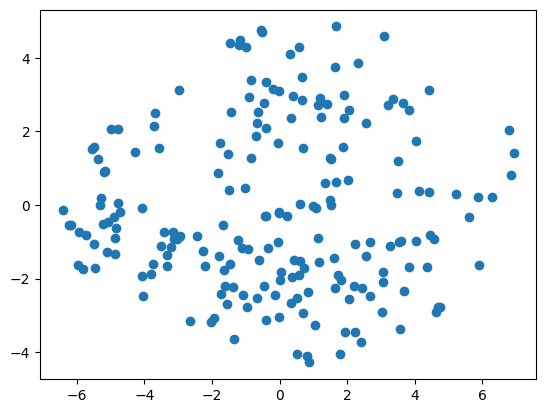

In [6]:
pca = PCA(n_components=2, svd_solver='full')
vgg_2comp = pca.fit_transform(vgg.T)
index = np.random.choice(vgg_2comp.shape[0], 200, replace=False)
plt.scatter(x=vgg_2comp[index,0], y=vgg_2comp[index,1])
plt.show()

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


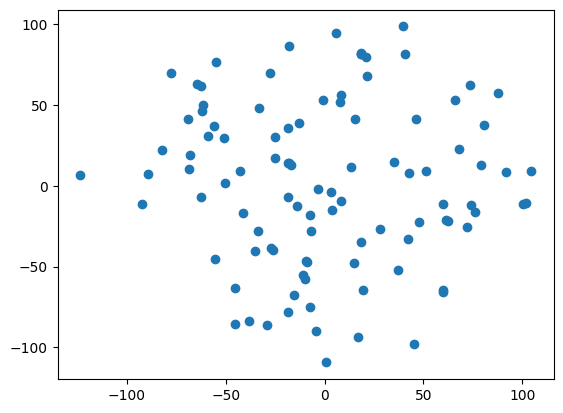

In [7]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000, init="pca", learning_rate="auto")
tsne_results = tsne.fit_transform(vgg.T)
index = np.random.choice(tsne_results.shape[0], 100, replace=False)
plt.scatter(x=tsne_results[index,0], y=tsne_results[index,1])
plt.show()

## The first few images should be able to form "clusters"

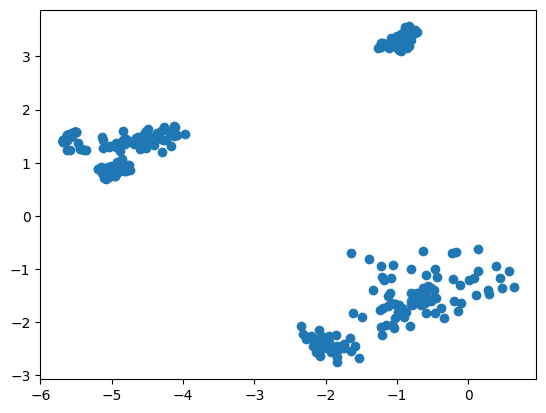

In [7]:
pca = PCA(n_components=2, svd_solver='full')
vgg_2comp = pca.fit_transform(vgg.T)
plt.scatter(x=vgg_2comp[:400,0], y=vgg_2comp[:400,1])
plt.show()

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


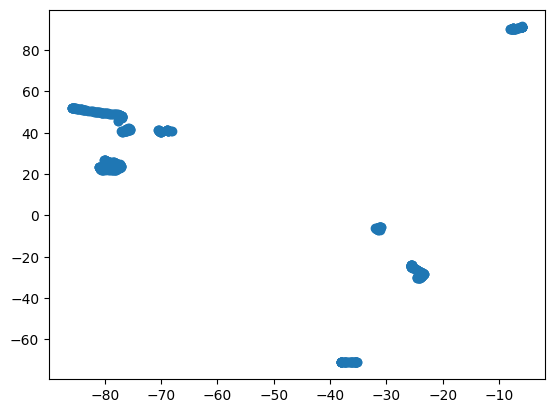

In [8]:
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000, init="pca", learning_rate="auto")
tsne_results = tsne.fit_transform(vgg.T)
plt.scatter(x=tsne_results[:400,0], y=tsne_results[:400,1])
plt.show()

## How often do scenes change?

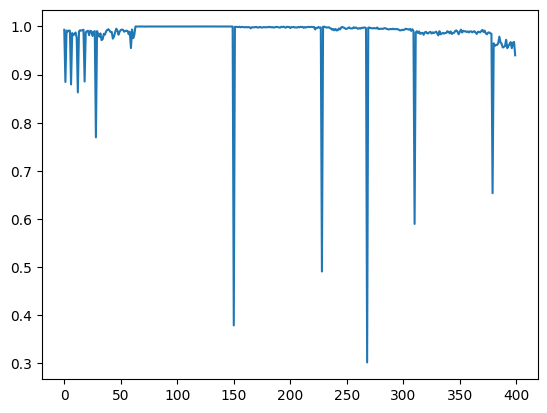

In [9]:
sim_scores = []

for i in range(400):
    sim = cos_sim(vgg.T[i], vgg.T[i+1])
    sim_scores.append(sim)

plt.plot(sim_scores)
plt.show()

# Outliers

In [4]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(vgg.T)

components = pca.components_
base = components.T
proj = base@inv(base.T@base)@base.T

In [40]:
max_sim = 0
i_max = 0
min_sim = 1
i_min = 0
sim_scores = np.zeros(vgg.T.shape[0])

for i in range(vgg.T.shape[0]):
    b_hat = proj@vgg.T[i]
    sim = cos_sim(vgg.T[i], b_hat)
    sim_scores[i] = sim

    if sim > max_sim:
        i_max = i
        max_sim = sim
    
    if sim < min_sim:
        i_min = i
        min_sim = sim

In [41]:
videopath = "bestofgiro2022.mp4"

cap = cv2.VideoCapture(videopath)

cap.set(cv2.CAP_PROP_POS_FRAMES, i_max-1)
res, max_frame = cap.read()

cap.set(cv2.CAP_PROP_POS_FRAMES, i_min-1)
res, min_frame = cap.read()

cv2.imwrite("most_similar.jpg", max_frame)
cv2.imwrite("least_similar.jpg", min_frame)

True

In [45]:
threshold = 0.9
over = np.count_nonzero(sim_scores > threshold)
print(f"{over/vgg.T.shape[0] * 100:.2f}% of frames have a cosine similarity of {threshold} or above with its projected vector")

96.56% of frames have a cosine similarity of 0.9 or above with its projected vector


## Isolation forests? Local Outliet Factor?

# Failed Attempt

In [3]:
centered_vgg = (vgg.T - np.mean(vgg.T, axis=0))
u, s, v = svd(centered_vgg)

In [28]:
norm(v[0]), norm(v[1])

(1.0, 1.0)

# Skeletons

In [79]:
skeletons

array([[0.00000000e+00, 0.00000000e+00, 1.63000000e+02, ...,
        1.38200000e+04, 1.38200000e+04, 1.38200000e+04],
       [0.00000000e+00, 0.00000000e+00, 4.29812347e+02, ...,
        2.70253113e+02, 2.97462616e+02, 3.80876770e+02],
       [0.00000000e+00, 0.00000000e+00, 1.85498398e+02, ...,
        4.73273544e+01, 1.15440277e+02, 8.03681030e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.42769714e+02, ...,
        2.74482635e+02, 2.82593658e+02, 4.03746368e+02],
       [0.00000000e+00, 0.00000000e+00, 1.48617966e+02, ...,
        8.01726837e+01, 2.99943085e+02, 1.59247894e+02],
       [0.00000000e+00, 0.00000000e+00, 6.20650873e-02, ...,
        9.50773340e-03, 2.68178005e-02, 5.22439927e-02]])